# Assignment 3 - Build a Seq2Seq Language Translation model for any language pair of your choice.

## Build a word model with attention or a transformer model

In [1]:
%env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

env: PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python


Importing libraries

In [2]:
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import io
from string import digits

We are performing English - Spanish translation. Reading the translation data from local downloaded from Anki

In [ ]:
file = "spa.txt"
datum= pd.read_table(file,names=['input', 'target'])
datum.head()

,input,target
Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


Text pre-processing with following-
all lower cases, cleaning digits and different symbols, punctuations.
Also adding 'start_ ' and ' _end' tags to each statement

In [ ]:
def preprocessing(sentence):
    num_digits= str.maketrans('','', digits)
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.lower()

    sentence= sentence.translate(num_digits)
    sentence= sentence.strip()
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    return sentence

Creating a word pair for the 2 languagesafter preprocessing

In [ ]:
stmts = io.open(file, encoding='UTF-8').read().strip().split('\n')
words = [[preprocessing(word) for word in s.split('\t')]  for s in stmts[:60000]]
inputt, target,_ = zip(*words)

create a tokenizer for the source sentences. For this, we need to vectorize the text  i.e. convert it into a sequence of integers with each word paired with a unique integer value. Then we post pad these sequences with '0' to make them equal length. We tokenize the Target sentences in similar way

In [ ]:
inputt_stmts_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
inputt_stmts_tokenizer.fit_on_texts(inputt)
inputt_tensor = inputt_stmts_tokenizer.texts_to_sequences(inputt)
inputt_tensor= tf.keras.preprocessing.sequence.pad_sequences(inputt_tensor,padding='post' )
max_source_length= max(len(t) for t in  inputt_tensor)
target_stmts_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_stmts_tokenizer.fit_on_texts(target)
target_tensor = target_stmts_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )
max_target_length= max(len(t) for t in  target_tensor)

Creating training and test data partition with 80:20

In [ ]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(inputt_tensor, target_tensor,test_size=0.2)

In [ ]:
BUFFER_SIZE = len(source_train_tensor)
BATCH_SIZE = 128
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
units = 512
vocab_inp_size = len(inputt_stmts_tokenizer.word_index)+1
vocab_tar_size = len(target_stmts_tokenizer.word_index)+1

#Creating dataset in memory for processing and slicing
dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
example_input_batch, example_target_batch = next(iter(dataset))

2022-11-19 13:59:30.384272: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-19 13:59:30.385311: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-19 13:59:30.430624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b3:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-19 13:59:30.430667: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-19 13:59:30.433494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-19 13:59:30.433669: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Defining and creating the Encoder

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_inp_size, units, batch):
    super(Encoder, self).__init__()
    self.batch = batch
    self.vocab_size = vocab_inp_size
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch, self.units))

In [ ]:
encoder = Encoder(vocab_inp_size, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

2022-11-19 13:59:32.433003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


We are using the Bahdanau Attention layer to handle the performance bottleneck of conventional encoder-decoder architectures

Reference: https://machinelearningmastery.com/the-bahdanau-attention-mechanism/


In [ ]:
class Atention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Atention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = Atention(18)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

2022-11-19 13:59:35.045874: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Defining and creating the decoder

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, units, batch):
    super(Decoder, self).__init__()
    self.batch = batch
    self.units = units
    # The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(vocab_size,
                                                self.units, mask_zero=True)
    
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # output will be the query for the attention layer.
    self.attention = Atention(self.units)

    
  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

In [ ]:
#Optimizer - Selecting Adam()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
#Loss function - Sparse Categorical CrossEntropy

obj = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def lossfn(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = obj(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Training the dataset using encoder-decoder model

In [ ]:
def training_step(inputt, targett, hidden):
  loss = 0
  ts= targett.shape[1]
  with tf.GradientTape() as tape:
    op, hidden = encoder(inputt, hidden)

    hidden = hidden

    ip = tf.expand_dims([target_stmts_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    for t in range(1,ts):
        
      predictions, hidden, _ = decoder(ip, hidden, op)

      loss += lossfn(targett[:, t], predictions)

      ip = tf.expand_dims(targett[:, t], 1)

  batch_loss = (loss / int(ts))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 25

for epoch in range(EPOCHS):

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = training_step(inp, targ, enc_hidden)
    total_loss += batch_loss
  print('Epoch', epoch + 1)
  print('Loss {:.4f}'.format(total_loss / steps_per_epoch))

Epoch 1
Loss 1.8972
Epoch 2
Loss 1.5056
Epoch 3
Loss 1.1846
Epoch 4
Loss 0.9216
Epoch 5
Loss 0.7139
Epoch 6
Loss 0.5533
Epoch 7
Loss 0.4351
Epoch 8
Loss 0.3488
Epoch 9
Loss 0.2838
Epoch 10
Loss 0.2381
Epoch 11
Loss 0.2029
Epoch 12
Loss 0.1757
Epoch 13
Loss 0.1541
Epoch 14
Loss 0.1387
Epoch 15
Loss 0.1256
Epoch 16
Loss 0.1130
Epoch 17
Loss 0.1032
Epoch 18
Loss 0.0993
Epoch 19
Loss 0.0927
Epoch 20
Loss 0.0841
Epoch 21
Loss 0.0787
Epoch 22
Loss 0.0743
Epoch 23
Loss 0.0712
Epoch 24
Loss 0.0690
Epoch 25
Loss 0.0685


Loss = 6% and Accuracy = 94%

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocessing(sentence)

  inputs = [inputt_stmts_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  output, hide = encoder(inputs, hidden)

  hide1 = hide
  input = tf.expand_dims([target_stmts_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, hide1, attention_weights = decoder(input,
                                                         hide1,
                                                         output)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_stmts_tokenizer.index_word[predicted_id] + ' '

    if target_stmts_tokenizer.index_word[predicted_id] == '_end':
      return result[:-6], sentence, attention_plot

    input = tf.expand_dims([predicted_id], 0)

  return result[:-6], sentence, attention_plot

In [ ]:
#Plot
def Plotatt(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 16}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, att = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Predicted translation: '+ result)

  att = att[:len(result.split(' ')), :len(sentence.split(' '))]
  Plotatt(att, sentence.split(' '), result.split(' '))
  return result

Input: start_ im up . _end
Predicted translation: estoy levantado .


/tmp/ipykernel_931094/3608462531.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_931094/3608462531.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


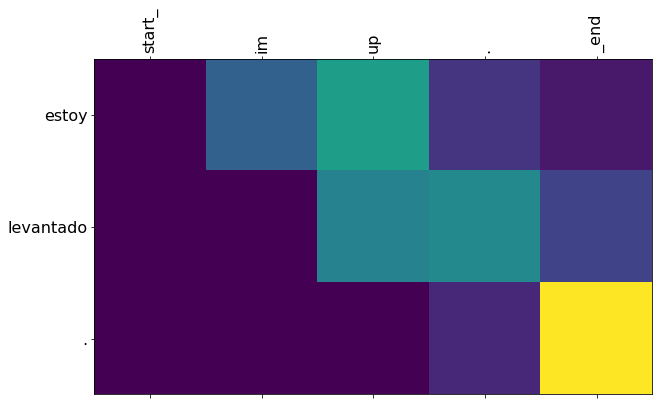

In [ ]:
translated = translate(u"Im up.")

Input: start_ this is a white dog . _end
Predicted translation: este es un perro blanco .


/tmp/ipykernel_931094/3608462531.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_931094/3608462531.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


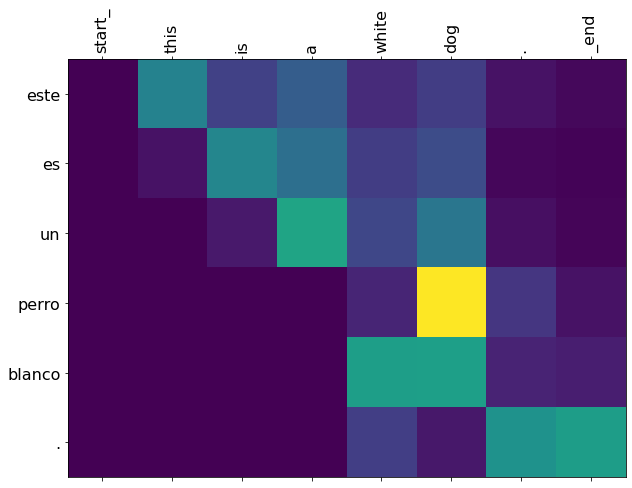

'este es un perro blanco .'

In [ ]:
translate(u"This is a white dog.")

Input: start_ tell me when you reach home . _end
Predicted translation: dime cuándo te golpeó en casa .


/tmp/ipykernel_931094/3608462531.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_931094/3608462531.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


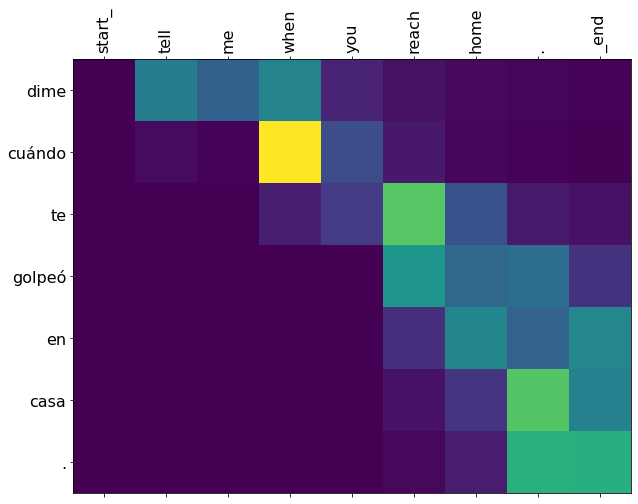

'dime cuándo te golpeó en casa .'

In [ ]:
translate(u"Tell me when you reach home.")